In [1]:
import importlib
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import itertools
import pandas as pd

import utils
from utils.download import get_data
from utils.var import calculate_var, exceeds_vector
from utils.methods import weighted_var, garch_var
from utils.tests import scoring_expectile

In [2]:
_ = importlib.reload(utils.download)
_ = importlib.reload(utils.var)

In [3]:
raw_data, params = get_data(yahoo=False)

In [4]:
frequency = params['frequency']

In [5]:
data = raw_data.resample(frequency).last()

In [6]:
data['returns'] = data.interpolate(type='linear').pct_change()

In [30]:
data = pd.read_csv("data\\historical_data.csv", index_col='Date')

# Metoda historyczna

In [31]:
data = calculate_var(data, lambda x: stats.expectile(x, .95), 'ehist')
data = calculate_var(data, lambda x: stats.expectile(x, .99), 'ehist', 99)

Wykres zwrotów i VaR95 dla zwrotów.

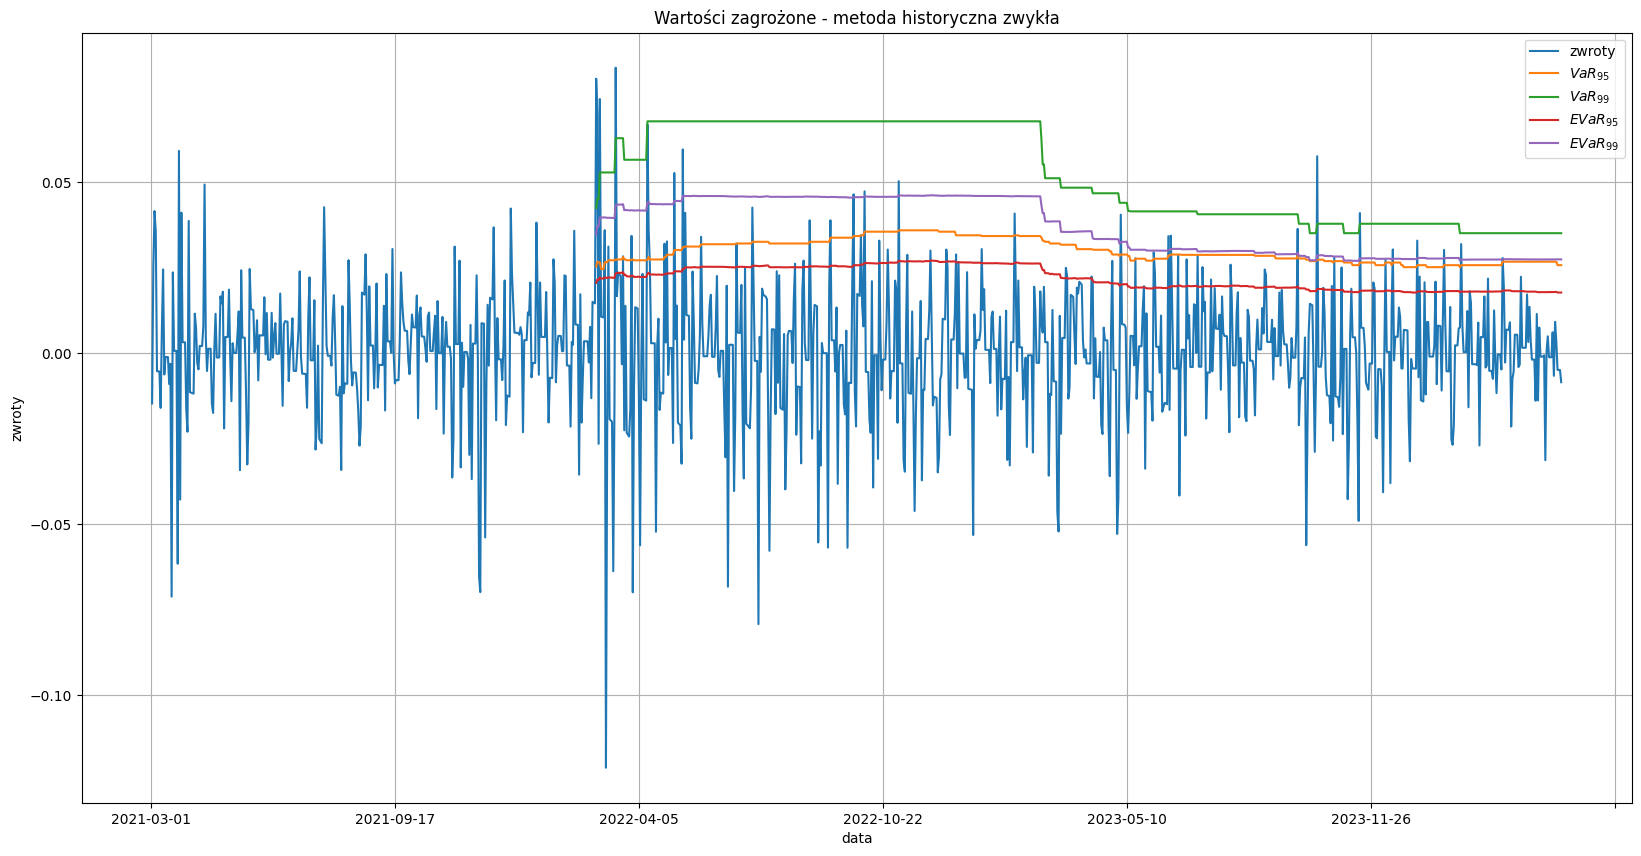

In [53]:
fig, ax = plt.subplots(figsize=(20,10))
_ = data[['returns', 'var95_hist', 'var99_hist', 'var95_ehist', 'var99_ehist']].\
    plot(ax=ax,
         grid=True,
         xlabel='data',
         title='Wartości zagrożone - metoda historyczna zwykła',
         ylabel='zwroty')
plt.legend(['zwroty', '$VaR_{95}$', '$VaR_{99}$', '$EVaR_{95}$', '$EVaR_{99}$'])
plt.savefig(f"pics\\{params['name']}\\evar_historyczna.png")

In [56]:
data, I95 = exceeds_vector(data, 'ehist')  # I - wektor przekroczeń
data, I99 = exceeds_vector(data, 'ehist', 99)

## Testowanie wsteczne

In [57]:
pd.set_option("display.precision", 10)

S95 = scoring_expectile(data.returns, data.var95_ehist, .95)
S99 = scoring_expectile(data.returns, data.var99_ehist, .99)

scoring_df = pd.DataFrame({'historyczna': [np.mean(S95), np.mean(S99)]}, index=[0.95, 0.99])
scoring_df

,historyczna
0.95,0.0000715020
0.99,0.0000278445


# Metoda ważonej symulacji historycznej

In [51]:
data = calculate_var(data, lambda x: weighted_var(x, .95, 'expectile'), 'eważona')
data = calculate_var(data, lambda x: weighted_var(x, .99, 'expectile'), 'eważona', 99)

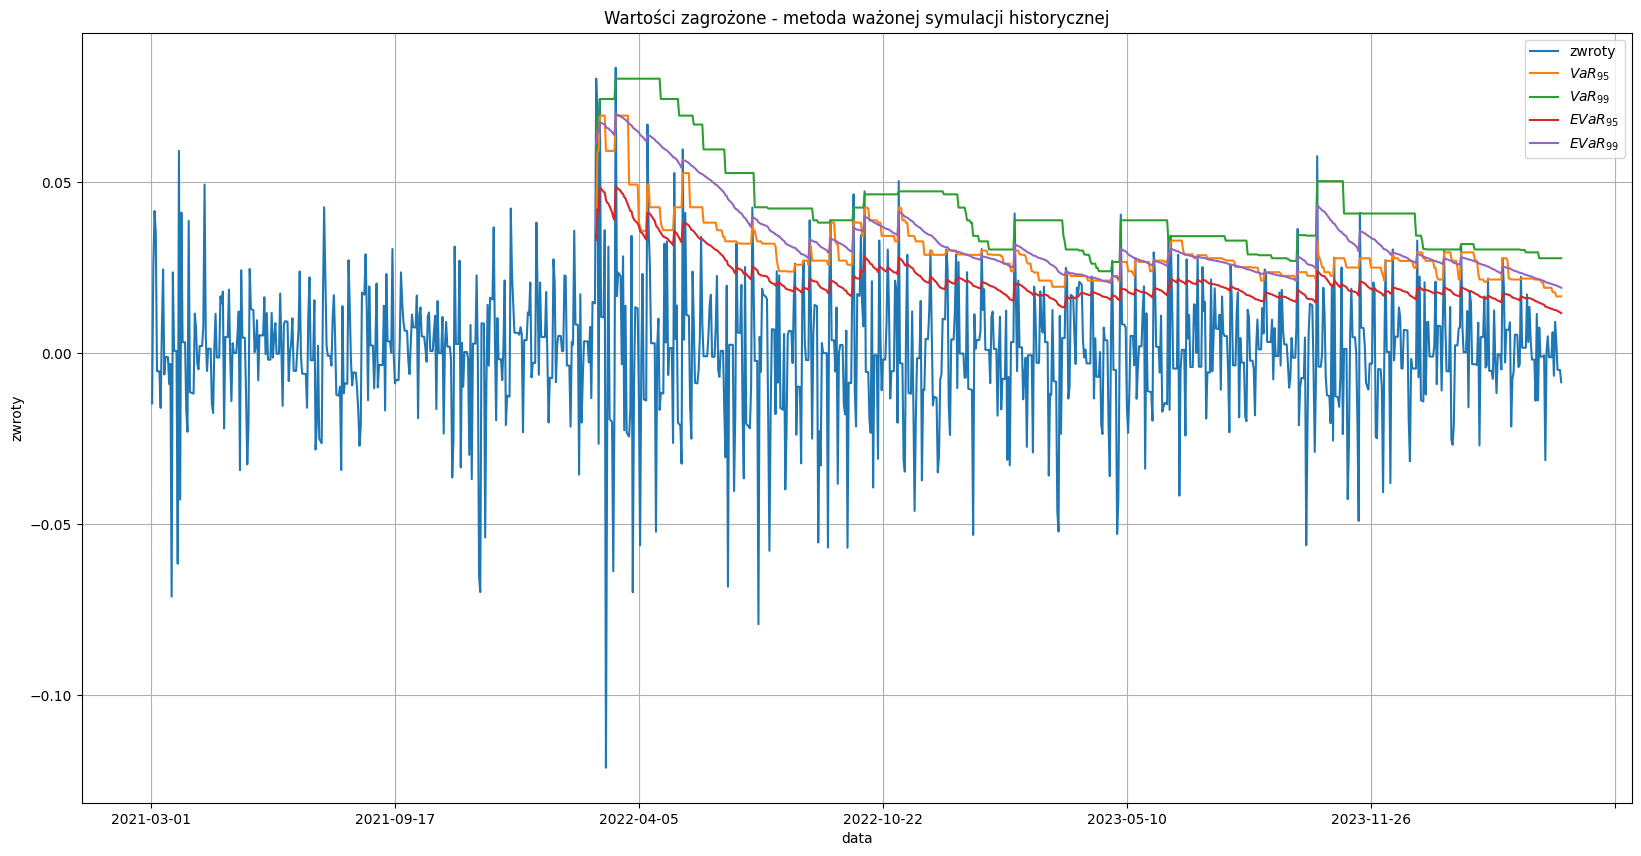

In [54]:
_, ax = plt.subplots(figsize=(20,10))
_ = data[['returns', 'var95_ważona','var99_ważona', 'var95_eważona','var99_eważona']].\
    plot(ax=ax,
         grid=True,
         xlabel='data',
         title='Wartości zagrożone - metoda ważonej symulacji historycznej',
         color=['C0', 'C1', 'C2', 'C3', 'C4'],
         ylabel='zwroty')
plt.legend(['zwroty', '$VaR_{95}$', '$VaR_{99}$', '$EVaR_{95}$', '$EVaR_{99}$'])
plt.savefig(f'pics\\{params["name"]}\\evar_wazona.png')

In [58]:
data, I95_weighted = exceeds_vector(data, 'eważona')
data, I99_weighted = exceeds_vector(data, 'eważona', 99)

## Testowanie wsteczne

In [59]:
S95_weighted = scoring_expectile(data.returns, data.var95_eważona, .95)
S99_weighted = scoring_expectile(data.returns, data.var99_eważona, .99)

scoring_df['ważona'] =  [np.mean(S95_weighted), np.mean(S99_weighted)]
scoring_df

,historyczna,ważona
0.95,0.0000715020,0.0000591843
0.99,0.0000278445,0.0000179612


# Metoda filtrowanej symulacji historycznej

In [48]:
%%capture
data = calculate_var(data, lambda x: garch_var(x, .95, 'expectile'), 'egarch', 95)
data = calculate_var(data, lambda x: garch_var(x, .99, 'expectile'), 'egarch', 99)

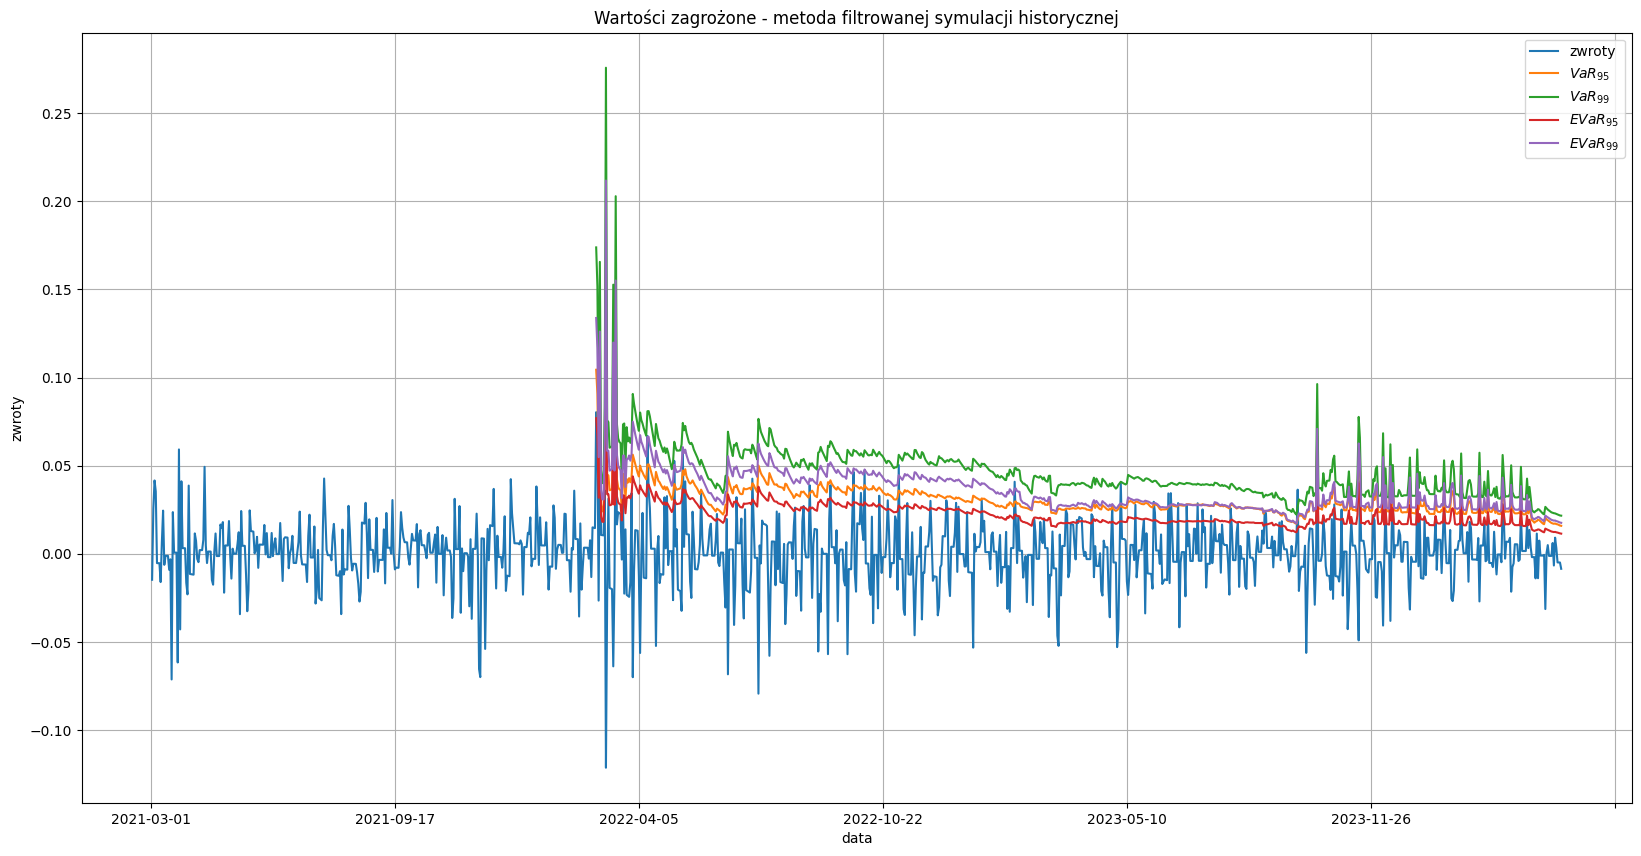

In [55]:
_, ax = plt.subplots(figsize=(20,10))
_ = data[['returns', 'var95_garch','var99_garch', 'var95_egarch','var99_egarch']].\
    plot(ax=ax,
         grid=True,
         xlabel='data',
         title='Wartości zagrożone - metoda filtrowanej symulacji historycznej',
         color=['C0', 'C1', 'C2', 'C3', 'C4'],
         ylabel='zwroty')
plt.legend(['zwroty', '$VaR_{95}$', '$VaR_{99}$', '$EVaR_{95}$', '$EVaR_{99}$'])
plt.savefig(f'pics\\{params["name"]}\\evar_garch.png')

## Testowanie wsteczne

In [60]:
S95_garch = scoring_expectile(data.returns, data.var95_garch, .95)
S99_garch = scoring_expectile(data.returns, data.var99_garch, .99)

scoring_df['garch'] =  [np.mean(S95_garch), np.mean(S99_garch)]
scoring_df

,historyczna,ważona,garch
0.95,0.0000715020,0.0000591843,0.0000730325
0.99,0.0000278445,0.0000179612,0.0000285511


# Porównanie

In [61]:
S95s = {'historyczna': S95, 'ważona': S95_weighted,'garch': S95_garch}
S99s = {'historyczna': S99, 'ważona': S99_weighted,'garch': S99_garch}

H0: the samples are drawn from populations with the same population means.

In [62]:
for a, b in itertools.combinations(S95s.keys(), 2):
    print(f'{a} vs {b}\n{stats.ttest_ind(S95s[a], S95s[b])}')

historyczna vs ważona
TtestResult(statistic=1.2713520929819866, pvalue=0.2037903037760475, df=1582.0)
historyczna vs garch
TtestResult(statistic=-0.147011248806525, pvalue=0.8831418734525409, df=1582.0)
ważona vs garch
TtestResult(statistic=-1.8041417469094676, pvalue=0.07139922479918943, df=1582.0)


In [63]:
for a, b in itertools.combinations(S99s.keys(), 2):
    print(f'{a} vs {b}\n{stats.ttest_ind(S99s[a], S99s[b])}')

historyczna vs ważona
TtestResult(statistic=2.3716226434795113, pvalue=0.017829291618962635, df=1582.0)
historyczna vs garch
TtestResult(statistic=-0.15249264498418258, pvalue=0.8788178366565693, df=1582.0)
ważona vs garch
TtestResult(statistic=-4.279954442251859, pvalue=1.9814719355391793e-05, df=1582.0)
